In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 
import seaborn as sns

In [2]:
## Datasets
data_domains=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\proteins-domains-from-Pfam.xlsx',header=0,index_col='Unnamed: 0')
data_domains=data_domains.dropna()
data_sl=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\data-synthetic-lethals.xlsx',header=0)
data_nonsl=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\data-positive-genetic.xlsx',header=0)



## Building the feature matrix
 One matrix for true SL where each column is one pair of SL. Every column will be a vector of  0,1 or 2 depending on the comparison with the domain list. for colum i the jth element = 0 if the jth element of the domain list is not in neither protein A and B, 1, if it is in one of them and 2 if it is in both of them .  




## Building the list of proteins domains id per protein pair separately :

1. List of protein A: Search for the Sl/nSL database the query gene name and look in the protein domain database which protein domains id has each of those queries.
2. List of protein B: Search for the Sl/nSL database the target gene name of the previous query and look in the protein domain database which protein domains id has each of those target genes.

In [3]:

# Selecting the meaningful columns in the respective dataset
domain_id_list=data_domains['domain-name']
query_gene=data_sl['gene-query-name']
target_gene=data_sl['gene-target-name']
query_gene_nonlethal=data_nonsl['gene-query-name']
target_gene_nonlethal=data_nonsl['gene-target-name']

# Initialising the arrays
protein_a_list=[]
protein_b_list=[]
protein_a_list_non=[]
protein_b_list_non=[]

# For loop for 500 pairs from the SL/nSl pair list , and creating a big array of proteind domains id per protein pair
for m in np.arange(0,5000):
    protein_a=data_domains[data_domains['name']==query_gene[m]]
    protein_b=data_domains[data_domains['name']==target_gene[m]]
    protein_a_list.append(protein_a['domain-name'].tolist())
    protein_b_list.append(protein_b['domain-name'].tolist())

    protein_a_non=data_domains[data_domains['name']==query_gene_nonlethal[m]]
    protein_b_non=data_domains[data_domains['name']==target_gene_nonlethal[m]]
    protein_a_list_non.append(protein_a_non['domain-name'].tolist())
    protein_b_list_non.append(protein_b_non['domain-name'].tolist())
    

## removed protein pairs from study if either protein in the pair does not contain any domain


In [4]:
def remove_empty_domains(protein_list_search,protein_list_pair):
    index=[]
    for i in np.arange(0,len(protein_list_search)):
        if protein_list_search[i]==[]:
            index.append(i) ## index of empty values for the protein_a_list meaning they dont have any annotated domain

    y=[x for x in np.arange(0,len(protein_list_search)) if x not in index] # a list with non empty values from protein_a list

    protein_list_search_new=[]
    protein_list_pair_new=[]
    for i in y:
        protein_list_search_new.append(protein_list_search[i])
        protein_list_pair_new.append(protein_list_pair[i])
    return protein_list_search_new,protein_list_pair_new

## evaluating the function

protein_a_list_new,protein_b_list_new=remove_empty_domains(protein_a_list,protein_b_list)
protein_a_list_non_new,protein_b_list_non_new=remove_empty_domains(protein_a_list_non,protein_b_list_non)

## Select from each ordered indexes of  domain id list which of them appear once, in both or in any of the domains of each protein pair

In [5]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y] # a function that give the index of whether a value appear in array or not
a=[1,2,3,4,5,6,7,8,9,10]
get_indexes(20,a)

[]

In [6]:
def feature_building(protein_a_list_new,protein_b_list_new):
    x = np.unique(domain_id_list)
    protein_feat_true=np.zeros(shape=(len(x),len(protein_a_list_new)))
    pair_a_b_array=[]
    for i in np.arange(0,len(protein_a_list_new)):
        index_a=[]
        pair=[protein_a_list_new[i],protein_b_list_new[i]]
        pair_a_b=np.concatenate(pair).ravel()
        pair_a_b_array.append(pair_a_b)

    for i in np.arange(0,len(pair_a_b_array)):  
        array,index,counts=np.unique(pair_a_b_array[i],return_index=True,return_counts=True)
        for k,m in zip(counts,array):
            if k ==2:
                protein_feat_true[get_indexes(m,x),i]=2
                
            if k==1:
                protein_feat_true[get_indexes(m,x),i]=1
            # print(index_a[m],i)
    return protein_feat_true

In [7]:
protein_feat_true=feature_building(protein_b_list_new=protein_b_list_new,protein_a_list_new=protein_a_list_new)
protein_feat_true_pd=pd.DataFrame(protein_feat_true.T)

protein_feat_non_true=feature_building(protein_b_list_new=protein_b_list_non_new,protein_a_list_new=protein_a_list_non_new)

protein_feat_non_true_pd=pd.DataFrame(protein_feat_non_true.T)
# stats_lethals=protein_feat_true_pd.describe()

## Build a feature matrix using the rows per protein pair:

- Feature 1: Mean of the each row per protein par (a long vector of 0, 1 and 2)
- feature 2: Number of 0 
- feature 3: Number of 1
- feature 4: Number of 2

In [8]:
feature_post_true=defaultdict(dict)

for ind in protein_feat_true_pd.index:
    feature_post_true[ind]['Mean']=np.mean(protein_feat_true_pd.iloc[ind,:])
    feature_post_true[ind]['std']=np.std(protein_feat_true_pd.iloc[ind,:])
    array,index,counts=np.unique(protein_feat_true_pd.iloc[ind,:],return_index=True,return_counts=True)
    # feature_post_true[ind]['array']=array
    for i in array:
        if i == 0:
            feature_post_true[ind]['Nr of zeros']=counts[np.where(array==0)[0][0]]
        if i==1:
            feature_post_true[ind]['Nr of ones']=counts[np.where(array==1)[0][0]]
        if i==2:
            feature_post_true[ind]['Nr of twos']=counts[np.where(array==2)[0][0]]
    

In [9]:
feature_post_true_pd=pd.DataFrame(feature_post_true)



In [10]:
feature_post_true_pd=feature_post_true_pd.T

feature_post_true_pd=feature_post_true_pd.fillna(0)

In [12]:
feature_post_true_pd['lethality']=np.ones(shape=(len(protein_a_list_new)))

In [15]:
feature_post_false=defaultdict(dict)

for ind in protein_feat_non_true_pd.index:
    feature_post_false[ind]['Mean']=np.mean(protein_feat_non_true_pd.iloc[ind,:])
    feature_post_false[ind]['std']=np.std(protein_feat_non_true_pd.iloc[ind,:])
    array,index,counts=np.unique(protein_feat_non_true_pd.iloc[ind,:],return_index=True,return_counts=True)
    for i in array:
        if i == 0:
            feature_post_false[ind]['Nr of zeros']=counts[np.where(array==0)[0][0]]
        if i==1:
            feature_post_false[ind]['Nr of ones']=counts[np.where(array==1)[0][0]]
        if i==2:
            feature_post_false[ind]['Nr of twos']=counts[np.where(array==2)[0][0]]

In [16]:
feature_post_false_pd=pd.DataFrame(feature_post_false)



In [17]:
feature_post_false_pd=feature_post_false_pd.fillna(0)
feature_post_false_pd=feature_post_false_pd.T

feature_post_false_pd['lethality']=np.zeros(shape=(len(protein_a_list_non_new)))



In [18]:
feature_post=pd.concat([feature_post_true_pd,feature_post_false_pd],axis=0)

In [20]:
feature_post=feature_post.set_index(np.arange(0,len(protein_a_list_new)+len(protein_a_list_non_new)))

In [21]:
feature_post.to_excel('positive-vs-SL-nr-of-0-and-1-as-features.xlsx')

In [4]:
#feature_post=pd.read_excel('feature-matrix.xlsx',index_col='Unnamed: 0')

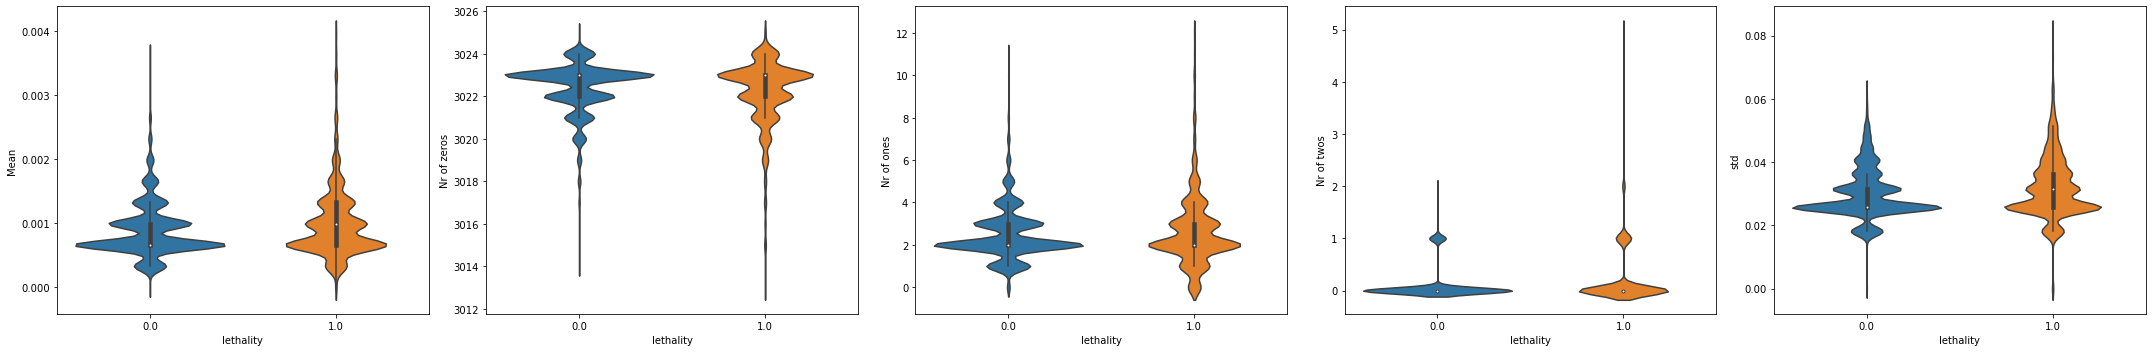

In [23]:
fig, axs = plt.subplots(ncols=5, figsize=(30,5))
sns.violinplot(x="lethality", y="Mean", data=feature_post,ax=axs[0])
sns.violinplot(x="lethality", y="Nr of zeros", data=feature_post,ax=axs[1])
sns.violinplot(x="lethality", y="Nr of ones", data=feature_post,ax=axs[2])
sns.violinplot(x="lethality", y="Nr of twos", data=feature_post,ax=axs[3])
sns.violinplot(x="lethality", y="std", data=feature_post,ax=axs[4])
plt.tight_layout()
#plt.savefig('output-images/corr-among-features-using-positive-interact.png',dpi=300,transparent=True,format='png')

In [86]:
#sns.distplot(feature_post['std']) Nice histogram using sns with fit

In [24]:
feature_post.corr()

,Mean,std,Nr of zeros,Nr of ones,Nr of twos,lethality
Mean,1.000000,0.913422,-0.960282,0.839185,0.334844,0.106980
std,0.913422,1.000000,-0.778726,0.574713,0.638198,0.120769
Nr of zeros,-0.960282,-0.778726,1.000000,-0.957605,-0.058620,-0.080372
Nr of ones,0.839185,0.574713,-0.957605,1.000000,-0.231455,0.046197
Nr of twos,0.334844,0.638198,-0.058620,-0.231455,1.000000,0.111326
lethality,0.106980,0.120769,-0.080372,0.046197,0.111326,1.000000


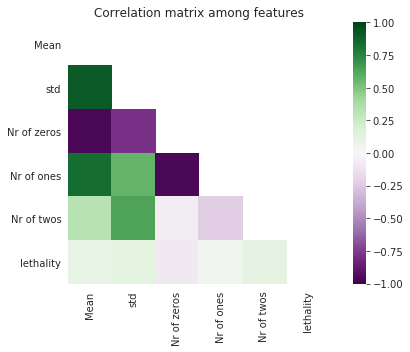

In [25]:
corr = feature_post.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
import matplotlib.cm as cm
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=1,vmin=-1 ,square=True,cmap=cm.PRGn)
ax.set_title('Correlation matrix among features')
plt.tight_layout()
#plt.savefig('output-images/corr-matrix-heatmap-among-features-using-positive-interact.png',dpi=300,transparent=True,format='png')

In [ ]:
# data_all.to_excel('feature-matrix-all.xlsx')

In [ ]:
############## Read the data ############################

# data_all=pd.read_excel('feature-matrix-all.xlsx')

In [92]:
X, y = feature_post.drop(columns=["lethality"]), feature_post["lethality"]


In [42]:
X, y = feature_post.drop(columns=["lethality",'Mean','std']), feature_post["lethality"]
X.columns

Index(['Nr of zeros', 'Nr of ones', 'Nr of twos'], dtype='object')

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.3, random_state= 0)

In [44]:
len(X_train)

7000

In [45]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_sc = sc_X.fit_transform(X_train)
X_test_sc = sc_X.transform(X_test)

In [8]:
len(X_train_sc)

7000

In [46]:
from sklearn.decomposition import PCA
pca = PCA() 
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1
print(k)

2


## how to check the importance of the features and how to plot a biplot. From [this question in stackoverflow](https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis)

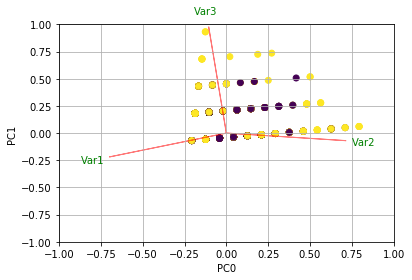

In [47]:
def myplot(score,coeff,labels=None,c=y_train):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = c)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(0))
plt.ylabel("PC{}".format(1))
plt.grid()

#Call the function. Use only the 2 PCs.
#pca = PCA()
myplot(X_train_pca[:,0:np.shape(X_train_pca)[1]],np.transpose(pca.components_[0:np.shape(X_train_pca)[1], :]))
plt.show()

**Now, the importance of each feature is reflected by the magnitude of the corresponding values in the eigenvectors (higher magnitude - higher importance)**

In [48]:
pca.explained_variance_ratio_


array([6.55876568e-01, 3.44123432e-01, 8.75893755e-30])

**PC0 explains ```array[0]``` and PC1 ```array[1]```. Together, if we keep PC0 and PC1 only, they explain ```array[0]+array[1]``` 0f the data.**

In [41]:
print(abs( pca.components_ ))

[[5.37337081e-01 4.76985239e-01 5.16805713e-01 4.31995644e-01
  1.73336553e-01]
 [4.62546995e-02 3.57591904e-01 2.29246898e-01 4.84422244e-01
  7.63393399e-01]
 [3.39830156e-01 8.02878018e-01 2.04927596e-01 4.08904868e-02
  4.42984200e-01]
 [1.07048152e-01 1.08246745e-15 7.23080001e-01 6.54872625e-01
  1.91931892e-01]
 [7.63010827e-01 3.16413562e-15 3.39878960e-01 3.84947615e-01
  3.92571146e-01]]


**Here, pca.components_ has shape  ```[n_components, n_features]```. Thus, by looking at the PC0 (First Principal Component) which is the first row: ```[0.67580333 0.71126353 0.19337543]```, we conclude that feature 1 and feature 2 are the most important **

## Multiple Linear Regression
![](multiple-linear-regression.png)

In [94]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Taken from [here](https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f)
In the case of multivariable linear regression, the regression model has to find the most optimal coefficients for all the attributes. To see what coefficients our regression model has chosen, execute the following script:

In [120]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns,columns=['Coefficient'])  

interc_df=pd.DataFrame(regressor.intercept_,X.columns,columns=['Intercept'])
coeff=pd.concat([coeff_df,interc_df],axis=1)

In [121]:
coeff

,Coefficient,Intercept
Mean,-1.520356e+06,4.610151e+12
std,-8.503313e-01,4.610151e+12
Nr of zeros,-1.524017e+09,4.610151e+12
Nr of ones,-1.524016e+09,4.610151e+12
Nr of twos,-1.524016e+09,4.610151e+12


In [98]:
y_pred = regressor.predict(X_test)

In [132]:

test_set_r2 = print('the r-squared is:',metrics.r2_score(y_test, y_pred))

the r-squared is: 0.011131317401421925


In [101]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(5)
df1

,Actual,Predicted
9394,0.0,0.514648
898,1.0,0.475586
2398,1.0,0.500000
5906,0.0,0.500000
2343,1.0,0.524414


In [102]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.49541145833333333
Mean Squared Error: 0.24720387585957845
Root Mean Squared Error: 0.497196013519395


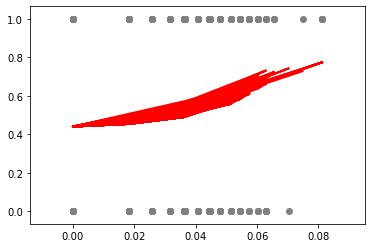

In [113]:
plt.scatter(X_test.iloc[:,1], y_test,  color='gray')
plt.plot(X_test.iloc[:,1], y_pred, color='red', linewidth=2)
plt.show()

There are many factors that may have contributed to this inaccuracy, for example :
- Need more data: We need to have a huge amount of data to get the best possible prediction.
- Bad assumptions: We made the assumption that this data has a linear relationship, but that might not be the case.Visualizing the data may help you determine that.
- Poor features: The features we used may not have had a high enough correlation to the values we were trying to predict.

In [122]:
import statsmodels.api as sm
# with statsmodels
X = sm.add_constant(X_train) # adding a constant
 
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test) 
 
print_model = model.summary()
print(print_model)

OLS Regression Results                            
Dep. Variable:              lethality   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     14.64
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.67e-09
Time:                        10:55:23   Log-Likelihood:                -5058.6
No. Observations:                7000   AIC:                         1.013e+04
Df Residuals:                    6996   BIC:                         1.015e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Mean         6.299e-05   3.75e-05      1.681      0.093   -1.04e-05       0.00

## Linear SVM

In [49]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification

clf_linear = LinearSVC(random_state=0, tol=1e-5,dual=False)


In [50]:
clf_linear.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

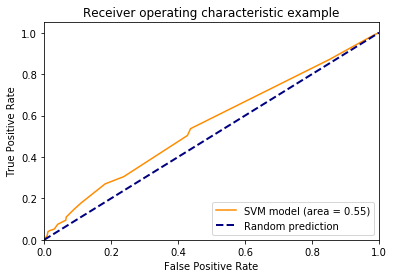

In [51]:
import sklearn.metrics as metrics
scores=clf_linear.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
area=metrics.auc(fpr,tpr)
plt.plot(fpr,tpr,color='darkorange',label='SVM model (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random prediction')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## General SVM

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
svm = SVC()
parameters = [{'C': [1, 10, 0.1], 'kernel': ['linear']},
              {'C': [1, 10, 0.1], 'kernel': ['rbf'], 'gamma': ['scale','auto']}]
clf = GridSearchCV(SVC(), parameters, n_jobs=-1, verbose=1)

clf.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.8s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 10, 0.1], 'kernel': ['linear']},
                         {'C': [1, 10, 0.1], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [53]:
best_parameters = clf.best_estimator_
print(best_parameters)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [54]:
model_svc=SVC(C=1, cache_size=200,break_ties=False, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
model_svc.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [55]:
y_pred_svc=model_svc.predict(X_test)

len(y_pred_svc[y_pred_svc==y_test]),len(y_pred_svc)

(1669, 3000)

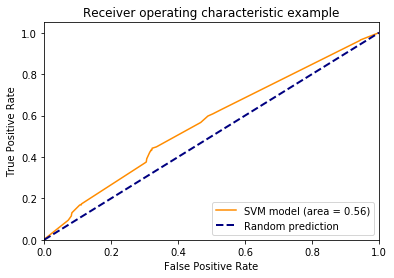

In [79]:
import sklearn.metrics as metrics
scores=model_svc.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
area=metrics.auc(fpr,tpr)
plt.plot(fpr,tpr,color='darkorange',label='SVM model (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random prediction')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('output-images/ROC-curve-SVC-on-classifing-lethality-using-PI-SL.png',format='png',dpi=300,transparent=False)

## Using Naive Bayes

In [75]:
from sklearn.naive_bayes import GaussianNB
model_nB = GaussianNB()
model_nB.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [76]:
from sklearn import metrics
predict_test = model_nB.predict(X_test)
print(metrics.accuracy_score(y_test, predict_test))

0.542


In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
print('Accuracy Score:',round(accuracy_score(y_test, y_pred_svc),2))
#confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)

Accuracy Score: 0.56


## Assessment for the general SVM classifier

In [61]:
y_pred_svc=model_svc.predict(X_test)

Text(0.5, 257.44, 'Predicted label')

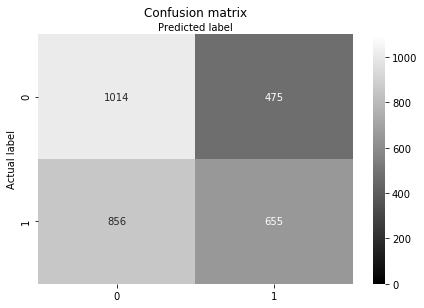

In [62]:
class_names=[1,2,3]
fig, ax = plt.subplots()
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

cm = confusion_matrix(y_test, y_pred_svc)
class_names=['SL', 'nSL']

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="gray" ,fmt='g',vmin=0,vmax=1100)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


Precision ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives($F_p$).

$P=\frac{T_p}{T_p+F_p}$

Recall ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives($F_n$).

$R=\frac{T_p}{T_p+F_n}$



In [63]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred_svc))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred_svc))

Precision: 0.5796460176991151
Recall: 0.43348775645268034


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.55')

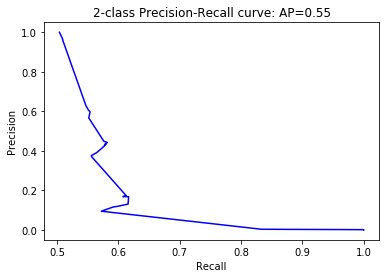

In [64]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, scores)
average_precision = metrics.average_precision_score(y_test, scores)
plt.plot(precision,recall,color='blue')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Feature importance

First of all, I assume that you call features the variables and not the samples/observations. In this case, you could do something like the following by creating a biplot function that shows everything in one plot. In this example I am using the iris data.

Before the example, please note that the basic idea when using PCA as a tool for feature selection is to select variables according to the magnitude (from largest to smallest in absolute values) of their coefficients (loadings). See my last paragraph after the plot for more details.

PART1: I explain how to check the importance of the features and how to plot a biplot.

PART2: I explain how to check the importance of the features and how to save them into a pandas dataframe using the feature names.





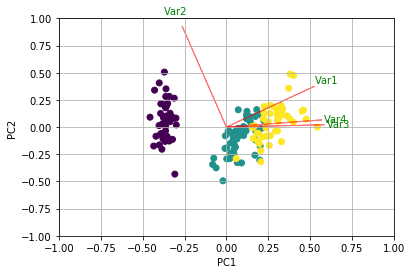

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris.data
y = iris.target
#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

pca = PCA()
x_new = pca.fit_transform(X)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()


Now, the importance of each feature is reflected by the magnitude of the corresponding values in the eigenvectors (higher magnitude - higher importance)

Let's see first what amount of variance does each PC explain.

pca.explained_variance_ratio_
[0.72770452, 0.23030523, 0.03683832, 0.00515193]
PC1 explains 72% and PC2 23%. Together, if we keep PC1 and PC2 only, they explain 95%.

Now, let's find the most important features.

print(abs( pca.components_ ))

[[0.52237162 0.26335492 0.58125401 0.56561105]
 [0.37231836 0.92555649 0.02109478 0.06541577]
 [0.72101681 0.24203288 0.14089226 0.6338014 ]
 [0.26199559 0.12413481 0.80115427 0.52354627]]
 
Here, pca.components_ has shape [n_components, n_features]. Thus, by looking at the PC1 (First Principal Component) which is the first row: [0.52237162 0.26335492 0.58125401 0.56561105]] we can conclude that feature 1, 3 and 4 (or Var 1, 3 and 4 in the biplot) are the most important.

To sum up, look at the absolute values of the Eigenvectors' components corresponding to the k largest Eigenvalues. In sklearn the components are sorted by explained_variance_. The larger they are these absolute values, the more a specific feature contributes to that principal component.

In [67]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
np.random.seed(0)

# 10 samples with 5 features
#train_features = np.random.rand(10,5)
train_features=X_train_sc
model = PCA(n_components=3).fit(train_features)
X_pc = model.transform(train_features)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['Nr of zeros','Nr of ones','Nr of twos']
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [68]:
df

,0,1
0,PC0,Nr of ones
1,PC1,Nr of twos
2,PC2,Nr of ones
